In [1]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:
import numpy as np
# for matplotlib
import matplotlib.pyplot as plt
from pydantic import BaseModel

# Experiment 2: Measure Glucose concentration in water

We measure glucose concentration in water using 8 difference concentration level

1. 0 mg/dL
2. 50 mg/dL
3. 100 mg/dL
4. 150 mg/dL
5. 200 mg/dL
6. 300 mg/dL
7. 400 mg/dL
8. 500 mg/dL

In [2]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def _single_load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

def load_data(filenames:List[str], x_range:XRange=None, basepath:str="./data") -> np.array:
    import os
    spectrums = []
    for f in filenames:
        # print(f)
        spectrum = _single_load_data(filename=f, x_range=x_range, basepath=basepath)
        spectrums.append(spectrum)

    # avergae
    spectrums = np.array(spectrums)
    spectrums = spectrums.mean(axis=0)
    return spectrums

## Preprocessing

https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f

In [3]:
from glob import glob
import os 
data = {}
key_bin = []
filepaths = sorted(glob("./data/*"))

x_range = XRange(lower_limit=600, higher_limit=1500)
for filepath in filepaths:
    basepath, filename = os.path.split(filepath)
    spectrum = load_data(filename=filename, x_range=x_range, basepath=basepath)
    glucose_value = filename.split('_')[0]
    key_bin.append(glucose_value)

    key = f"{glucose_value}_{key_bin.count(glucose_value)}"
    data[key] = {
        'glucose':int(glucose_value),
        'filename':(filename),
        'spectrum':spectrum
    }


color_map = {
    0:"tab:blue",
    50:"tab:orange",
    100:"tab:green",
    150:"tab:red",
    200:"tab:purple",
    300:"tab:brown",
    400:"tab:pink",
    500:"tab:gray",
}


In [4]:
data_agg = {}
for key in [0,50,100,150,200,300,400,500]:
    spectrum = None
    for filepath in glob(f"./data/{key}_*"):
        basepath, filename = os.path.split(filepath)
        temp = load_data(filename=filename, x_range=x_range, basepath=basepath)
        if spectrum == None:
            spectrum = temp.copy()
        else:
            spectrum += temp.copy()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import matplotlib.colors as mcolors
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

<Figure size 500x500 with 0 Axes>

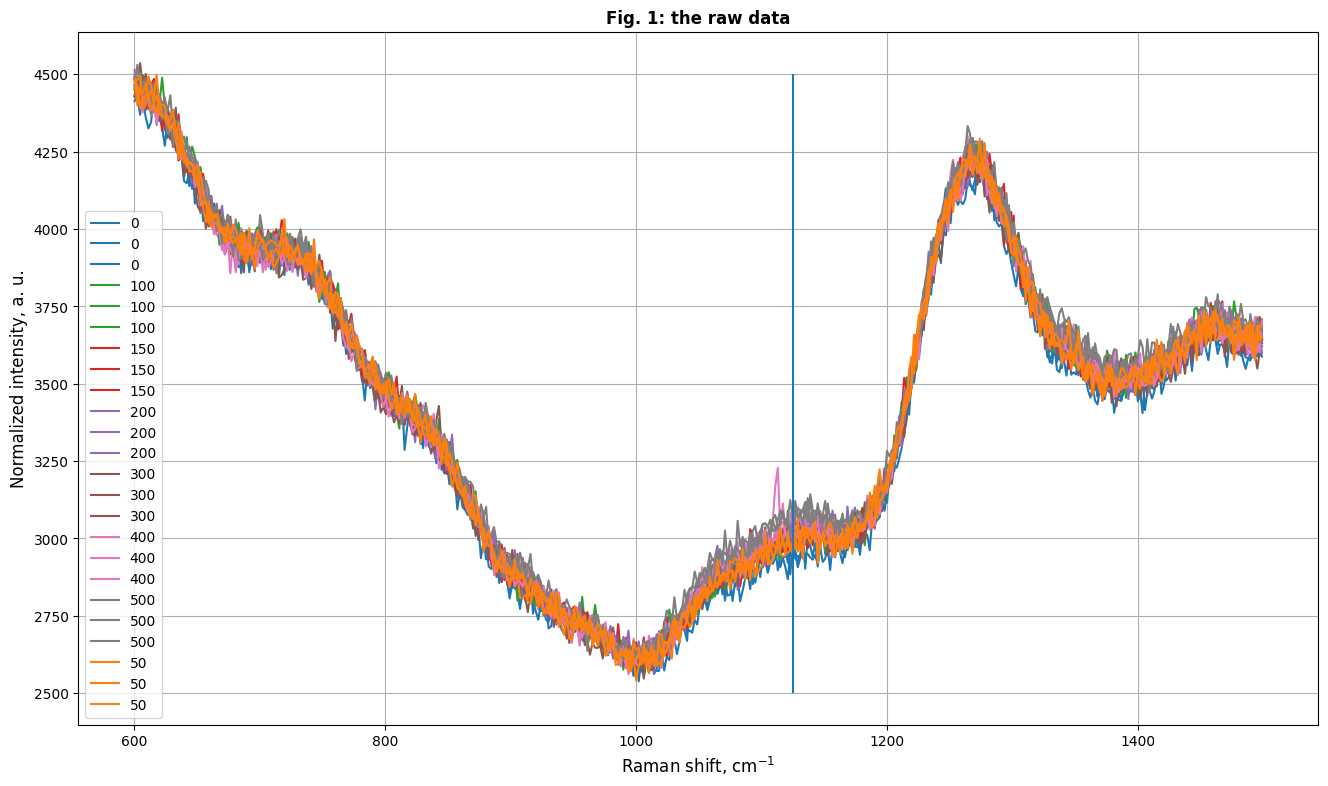

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))


for key,item in data.items():
    spectrum = item['spectrum'].copy()
    glucose = item['glucose']
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=4500, ymin=2500)
# ax.set_ylim(ymax=3200, ymin=2700)
# ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()

## Despike

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian
import sklearn.linear_model as linear_model

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out



<Figure size 500x500 with 0 Axes>

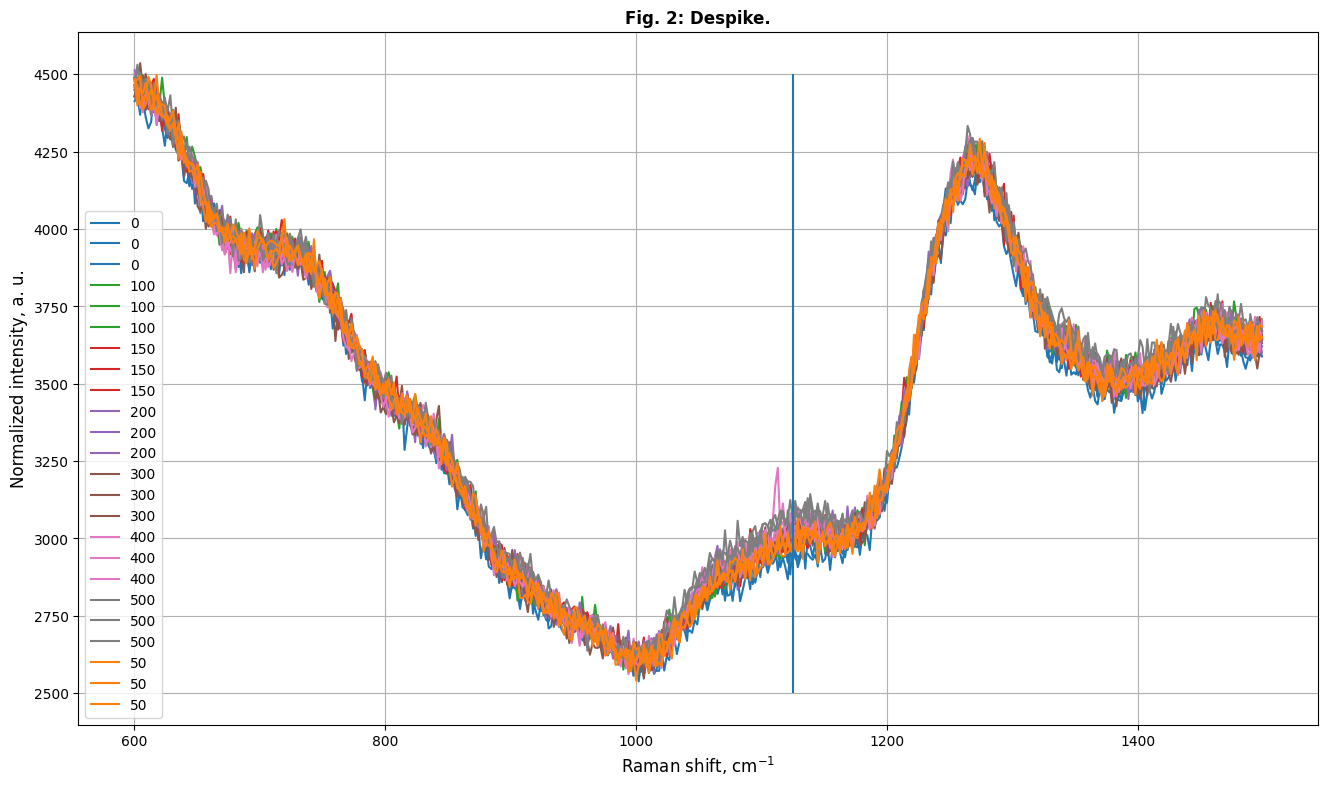

In [ ]:
plt.figure(figsize=(5,5))
fig,ax = plt.subplots(figsize=(16,9))


for key,item in data.items():
    spectrum = item['spectrum'].copy()
    glucose = item['glucose']
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    y = despike(y, window_size=10)
    # We did not detect any spike
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 2: Despike.",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=4500, ymin=2500)
# ax.set_ylim(ymax=3200, ymin=2700)
# ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()

## Baseline separation

In [ ]:
# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parameters for this case:
lam = 10000000 # smoothness
p = 0.05 # asymmetry
# Baseline stimation function:
def baseline_als(y, lam, p, n_epoch=100) -> np.array:
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_epoch):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    corrected_y = y.copy() - z.copy()
    return corrected_y, z

<Figure size 500x500 with 0 Axes>

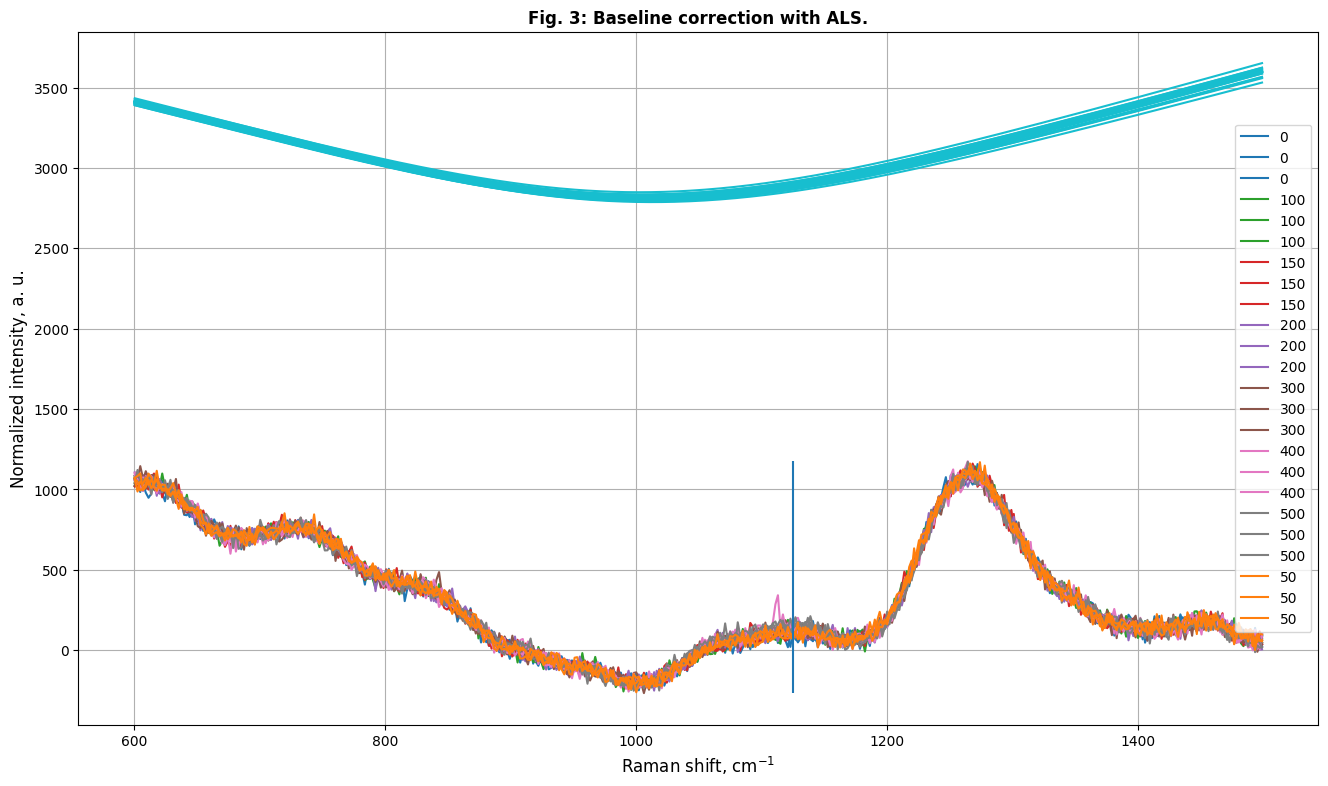

In [ ]:
plt.figure(figsize=(5,5))
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf
for key,item in data.items():
    spectrum = item['spectrum'].copy()
    glucose = item['glucose']
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    y, baseline = baseline_als(y, lam=lam, p=p)
    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    ax.plot(x,baseline,markersize=1, c='tab:cyan')

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 3: Baseline correction with ALS.",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
# ax.set_ylim(ymax=3200, ymin=2700)
# ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()

## Smoothing

In [ ]:
from scipy.signal import savgol_filter, general_gaussian

<Figure size 500x500 with 0 Axes>

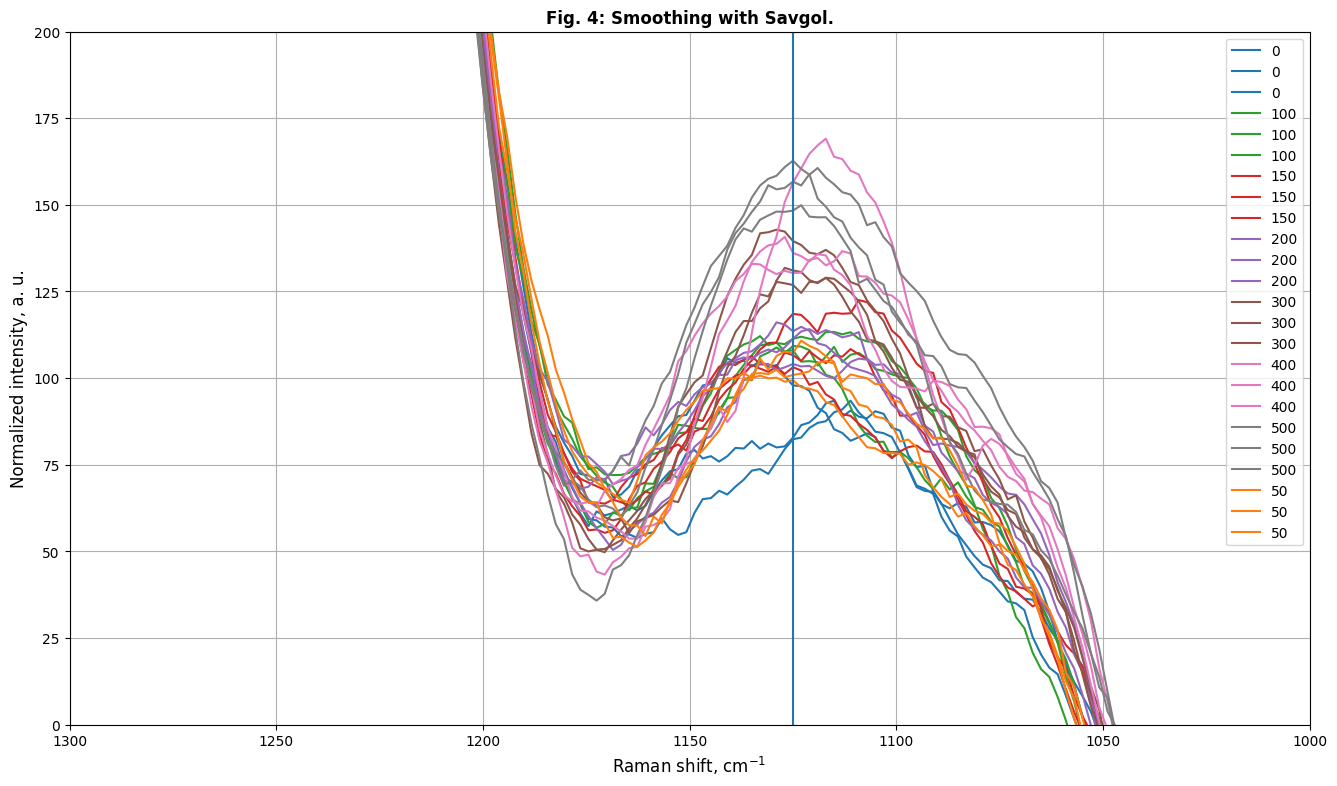

In [ ]:
plt.figure(figsize=(5,5))
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf
for key,item in data.items():
    spectrum = item['spectrum'].copy()
    glucose = item['glucose']
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    y, baseline = baseline_als(y, lam=lam, p=p)
    y = savgol_filter(y.copy(), window_length=30, polyorder=2, deriv=0)
    
    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()

    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 4: Smoothing with Savgol.",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.set_ylim(ymax=200, ymin=0)
ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf

for key in [0,50,100,150,200,300,400,500]:
    spectrum = data[f"{key}_1"]['spectrum']


for key,item in data.items():
    spectrum = item['spectrum'].copy()
    glucose = item['glucose']
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    y, baseline = baseline_als(y, lam=lam, p=p)
    y = savgol_filter(y.copy(), window_length=30, polyorder=2, deriv=0)
    
    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()

    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 4: Smoothing with Savgol.",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.set_ylim(ymax=200, ymin=0)
ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()

In [ ]:
spectrum = data[f"0_1"]['spectrum']
spectrum

array([[ 600.741, 4465.   ],
       [ 602.933, 4431.   ],
       [ 605.124, 4418.   ],
       [ 607.315, 4420.   ],
       [ 609.505, 4362.   ],
       [ 611.694, 4325.   ],
       [ 613.882, 4346.   ],
       [ 616.069, 4443.   ],
       [ 618.255, 4443.   ],
       [ 620.44 , 4379.   ],
       [ 622.625, 4345.   ],
       [ 624.809, 4371.   ],
       [ 626.992, 4357.   ],
       [ 629.173, 4341.   ],
       [ 631.354, 4306.   ],
       [ 633.535, 4305.   ],
       [ 635.714, 4257.   ],
       [ 637.893, 4290.   ],
       [ 640.071, 4169.   ],
       [ 642.248, 4236.   ],
       [ 644.424, 4141.   ],
       [ 646.599, 4173.   ],
       [ 648.773, 4111.   ],
       [ 650.947, 4113.   ],
       [ 653.119, 4108.   ],
       [ 655.291, 4078.   ],
       [ 657.462, 4038.   ],
       [ 659.632, 4010.   ],
       [ 661.801, 4046.   ],
       [ 663.969, 4004.   ],
       [ 666.137, 4011.   ],
       [ 668.304, 3984.   ],
       [ 670.469, 3991.   ],
       [ 672.635, 3924.   ],
       [ 674.7

In [ ]:
data

{'0_1': {'glucose': 0,
  'filename': '0_600_785 nm_60 s_1_2024_03_18_14_46_49_01.txt',
  'spectrum': array([[ 600.741, 4465.   ],
         [ 602.933, 4431.   ],
         [ 605.124, 4418.   ],
         [ 607.315, 4420.   ],
         [ 609.505, 4362.   ],
         [ 611.694, 4325.   ],
         [ 613.882, 4346.   ],
         [ 616.069, 4443.   ],
         [ 618.255, 4443.   ],
         [ 620.44 , 4379.   ],
         [ 622.625, 4345.   ],
         [ 624.809, 4371.   ],
         [ 626.992, 4357.   ],
         [ 629.173, 4341.   ],
         [ 631.354, 4306.   ],
         [ 633.535, 4305.   ],
         [ 635.714, 4257.   ],
         [ 637.893, 4290.   ],
         [ 640.071, 4169.   ],
         [ 642.248, 4236.   ],
         [ 644.424, 4141.   ],
         [ 646.599, 4173.   ],
         [ 648.773, 4111.   ],
         [ 650.947, 4113.   ],
         [ 653.119, 4108.   ],
         [ 655.291, 4078.   ],
         [ 657.462, 4038.   ],
         [ 659.632, 4010.   ],
         [ 661.801, 4046.   ],
  